# Train a classification model on a smal subset of labeled data

A small subset of the data should be labeled by placing them in an appropriate folder corresponding to thier label. 


In [73]:
import matplotlib.pyplot as plt
from matplotlib import image as mpimg
import numpy as np
import os
import pickle

import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D

import IPython.display as ipd

np.random.seed(1000)


Mount google dirve

In [74]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


## Load data from directory

A subset of this data is used for training and another subset for validation. 

In [75]:
data_dir = "/content/gdrive/MyDrive/Capstone_project/Phone_Rec_020222/train/"

dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir, image_size=(227, 227), 
                                                              batch_size=16, seed=9, 
                                                              color_mode='rgb', subset="training",
                                                              validation_split=0.2)

val_dataset = tf.keras.preprocessing.image_dataset_from_directory(data_dir, image_size=(227, 227), 
                                                              batch_size=16, seed=9, 
                                                              color_mode='rgb', subset="validation",
                                                              validation_split=0.2)


Found 71 files belonging to 5 classes.
Using 57 files for training.
Found 71 files belonging to 5 classes.
Using 14 files for validation.


## Unlabeled data

Unlabeled data is loaded into a single class. Using the method "file_paths" we are able to access the file name and path. The order of elements in the returned list corresponds to the order in which the images are placed in batches. This is only the case when "shuffle = False".

In [76]:
no_label_dir = '/content/gdrive/MyDrive/Capstone_project/Phone_Rec_020222/images/'

unlabeled_data = tf.keras.preprocessing.image_dataset_from_directory(no_label_dir, image_size=(227, 227), 
                                                                     batch_size=16, seed=9, shuffle = False,
                                                                     color_mode='rgb')

unlabeled_paths = unlabeled_data.file_paths

Found 15790 files belonging to 1 classes.


## Visualise a batch of training data

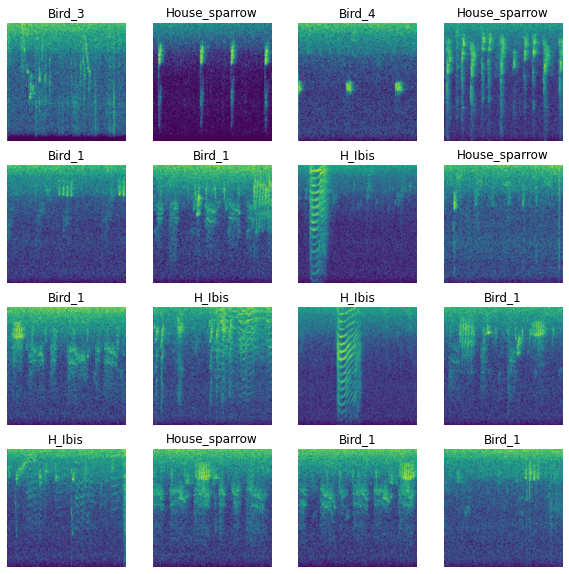

In [77]:
class_names = dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
  #print(images.shape,labels.shape)
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Visualise a batch of unlabeled data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  


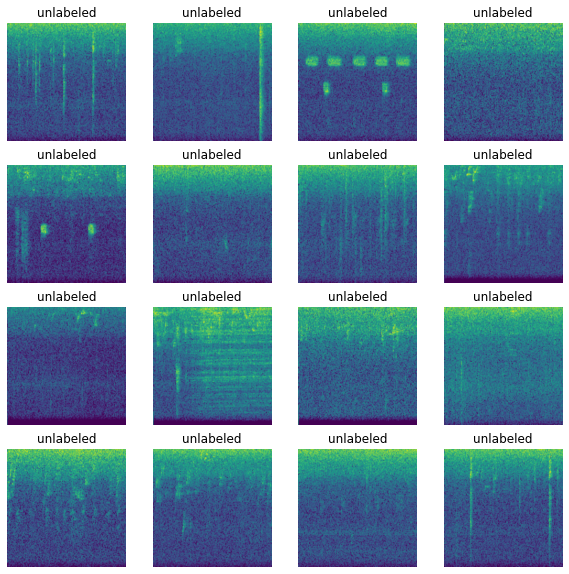

In [78]:
no_class_names = unlabeled_data.class_names
plt.figure(figsize=(10, 10))
for images, labels in unlabeled_data.take(12):
  #print(images.shape,labels.shape)
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')
    plt.title(no_class_names[labels[i]])
    plt.axis("off")

## Model

Model has the same stucture as AlexNet and is constructed using Keras (Tensorflow)

In [79]:
# (3) Create a sequential model
model = Sequential()

# Preprocessing, rescale pixel values to the interval [0, 1]
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(227,227,3)))

# 1st Convolutional Layer
model.add(Conv2D(filters=96, input_shape=(227,227,3), kernel_size=(11,11), strides=(4,4), padding='valid'))
model.add(Activation('relu'))
# Pooling 
model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
# Batch Normalisation before passing it to the next layer
model.add(BatchNormalization())


# 2nd Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='same'))
model.add(Activation('relu'))
# Pooling
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))
# Batch Normalisation
model.add(BatchNormalization())


# 3rd Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
model.add(Activation('relu'))
# Batch Normalisation
model.add(BatchNormalization())


# 4th Convolutional Layer
model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
model.add(Activation('relu'))
# Batch Normalisation
model.add(BatchNormalization())


# 5th Convolutional Layer
model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
model.add(Activation('relu'))
# Pooling
model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))
# Batch Normalisation
model.add(BatchNormalization())


# Passing it to a dense layer
model.add(Flatten())


# 1st Dense Layer
model.add(Dense(4096, input_shape=(224*224*3,)))
model.add(Activation('relu'))


# Add Dropout to prevent overfitting
model.add(Dropout(0.4))
# Batch Normalisation
model.add(BatchNormalization())


# 2nd Dense Layer
model.add(Dense(4096))
model.add(Activation('relu'))

# Add Dropout
model.add(Dropout(0.4))
# Batch Normalisation
model.add(BatchNormalization())

#  output Layer 
model.add(Dense(len(class_names)))

model.add(Activation('softmax'))

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_5 (Rescaling)     (None, 227, 227, 3)       0         
                                                                 
 conv2d_25 (Conv2D)          (None, 55, 55, 96)        34944     
                                                                 
 activation_37 (Activation)  (None, 55, 55, 96)        0         
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 27, 27, 96)       0         
 g2D)                                                            
                                                                 
 batch_normalization_35 (Bat  (None, 27, 27, 96)       384       
 chNormalization)                                                
                                                                 
 conv2d_26 (Conv2D)          (None, 27, 27, 256)      

Path to save checkpoints/model weights

In [80]:
ckpt_path = '/content/gdrive/MyDrive/Capstone_project/Phone_Rec_020222/'

## Compile model

Compile model with the option to restore "best" weights. Validation accuracy to monitored and training is stopped early if no change in validation accuracy is recorded for 10 epochs. 

In [81]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

model.compile(loss = keras.losses.sparse_categorical_crossentropy, optimizer= 'adam', metrics=['accuracy'])


## Train and save

Weights and history are saved. 

In [82]:
history = model.fit(dataset, validation_data=val_dataset, epochs=30, callbacks=[callback])

model.save_weights(ckpt_path+"best_weights.h5")

with open(ckpt_path+'trainHistoryDict', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)
    

Epoch 1/30
4/4 [==============================] - 29s 3s/step - loss: 2.3127 - accuracy: 0.4386 - val_loss: 3.6536 - val_accuracy: 0.1429
Epoch 2/30
4/4 [==============================] - 12s 3s/step - loss: 1.8400 - accuracy: 0.6140 - val_loss: 27.3023 - val_accuracy: 0.1429
Epoch 3/30
4/4 [==============================] - 12s 3s/step - loss: 1.3879 - accuracy: 0.7719 - val_loss: 87.0429 - val_accuracy: 0.1429
Epoch 4/30
4/4 [==============================] - 12s 3s/step - loss: 1.0120 - accuracy: 0.7193 - val_loss: 122.0424 - val_accuracy: 0.1429
Epoch 5/30
4/4 [==============================] - 12s 3s/step - loss: 0.5887 - accuracy: 0.7193 - val_loss: 113.4713 - val_accuracy: 0.1429
Epoch 6/30
4/4 [==============================] - 12s 3s/step - loss: 0.4851 - accuracy: 0.8070 - val_loss: 103.3938 - val_accuracy: 0.1429
Epoch 7/30
4/4 [==============================] - 12s 3s/step - loss: 0.5360 - accuracy: 0.8772 - val_loss: 111.5196 - val_accuracy: 0.1429
Epoch 8/30
4/4 [========

## Plot traing history

In [ ]:
# list all data in history
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Create second model identical to first but without the final softmax layer

In [84]:
# (3) Create a sequential model
model_2 = Sequential()

# Preprocessing, rescale pixel values to the interval [0, 1]
model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(227,227,3)))

# 1st Convolutional Layer
model_2.add(Conv2D(filters=96, input_shape=(227,227,3), kernel_size=(11,11), strides=(4,4), padding='valid'))
model_2.add(Activation('relu'))
# Pooling 
model_2.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='valid'))
# Batch Normalisation before passing it to the next layer
model_2.add(BatchNormalization())


# 2nd Convolutional Layer
model_2.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='same'))
model_2.add(Activation('relu'))
# Pooling
model_2.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))
# Batch Normalisation
model_2.add(BatchNormalization())


# 3rd Convolutional Layer
model_2.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
model_2.add(Activation('relu'))
# Batch Normalisation
model_2.add(BatchNormalization())


# 4th Convolutional Layer
model_2.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
model_2.add(Activation('relu'))
# Batch Normalisation
model_2.add(BatchNormalization())


# 5th Convolutional Layer
model_2.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
model_2.add(Activation('relu'))
# Pooling
model_2.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))
# Batch Normalisation
model_2.add(BatchNormalization())


# Passing it to a dense layer
model_2.add(Flatten())


# 1st Dense Layer
model_2.add(Dense(4096, input_shape=(224*224*3,)))
model_2.add(Activation('relu'))


# Add Dropout to prevent overfitting
model_2.add(Dropout(0.4))
# Batch Normalisation
model_2.add(BatchNormalization())


# 2nd Dense Layer
model_2.add(Dense(4096))
model_2.add(Activation('relu'))

# Add Dropout
model_2.add(Dropout(0.4))
# Batch Normalisation
model_2.add(BatchNormalization())

#  output Layer 
model_2.add(Dense(len(class_names)))

## Load weights from earlier training into model_2

In [85]:
model_2.load_weights(ckpt_path+"best_weights.h5", by_name=True) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:41: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


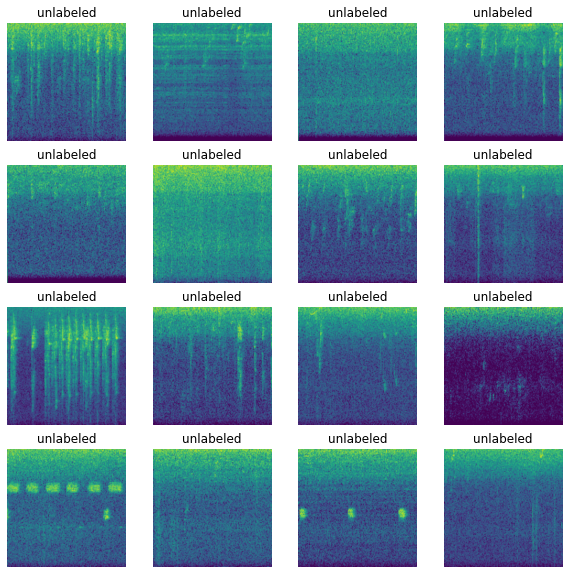

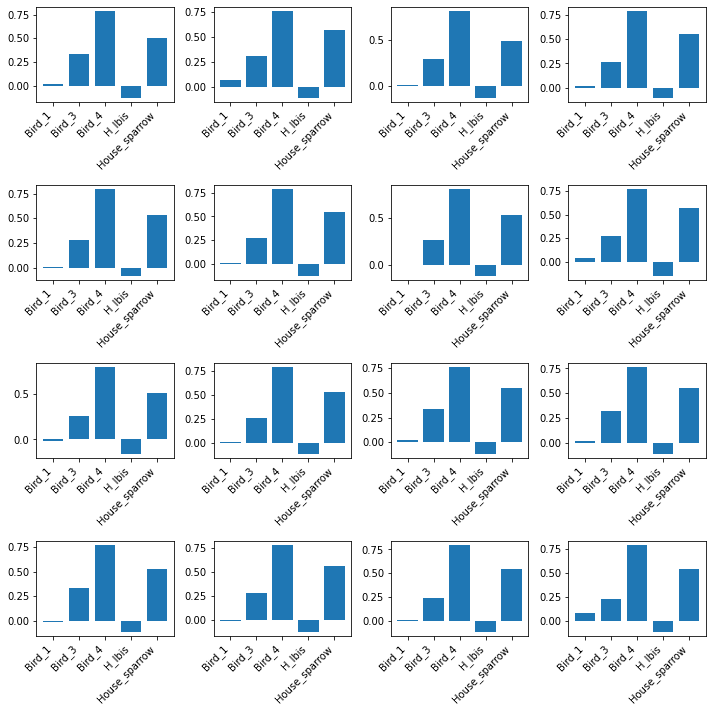

In [91]:
batch_count = 25

# Load batch number 'batch_count'
batch = unlabeled_data.take(batch_count)

# Pass this batch to the model
prediction_unlabeled = model_2.predict(batch)

# Nomalise output vectors
norms = np.linalg.norm(prediction_unlabeled, axis=1)
for i in range(len(prediction_unlabeled)):
  prediction_unlabeled[i] = prediction_unlabeled[i]/norms[i]

# Get paths of image files for this batch
batch_files = unlabeled_paths[0+16*(batch_count-1):16*batch_count]

# Ceate a list containing just the name of the files
# This is useful if we wish access the corresponding audio clips
batch_names = []
for txt in batch_files:
  dummy = txt.split('/')
  dummy = dummy[-1].split('.')
  batch_names.append(dummy[0])
batch = unlabeled_data.take(batch_count)

# Show images in batch
plt.figure(figsize=(10, 10))
for images, labels in batch:
  for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"), cmap='gray')
    plt.axis("off")

# Show output of model_2
plt.figure(figsize=(10, 10))
for i in range(16):
  ax = plt.subplot(4, 4, i + 1)
  plt.bar(class_names,prediction_unlabeled[i])
  plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# Play audio associated with batch
sound_dir = "/content/gdrive/MyDrive/Capstone_project/Phone_Rec_020222/splits/"
for name in batch_names:
  display(ipd.Audio(sound_dir+name+'.wav', autoplay=True))

## Confirm that the image names do indeed correspond to the images in the batch

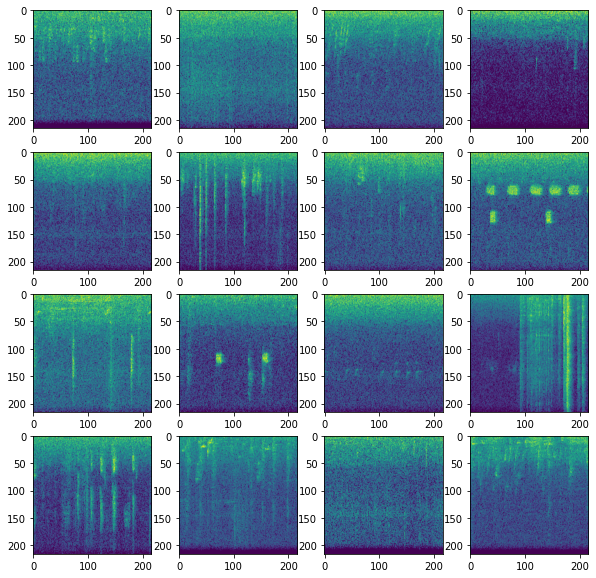

In [36]:
plt.figure(figsize=(10, 10))
i=0
for img in batch_files:
  ax = plt.subplot(4, 4, i + 1)
  image = mpimg.imread(img)
  plt.imshow(image)
  i+=1

## Self labeling
If there is a significant positive result for a certain class then that image should be added to the class. Once all unlabeled images have been processed the model training is continued with the new image set (origial set + self-labeled images). This process is repeated until all images are labeled. 

In [ ]:
# Not completed